In [33]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:

file_path = '../../data/processed/feature_selected_data.parquet'
df = pd.read_parquet(file_path, engine= 'pyarrow')

In [35]:
df.descrizione_attivita.value_counts()

descrizione_attivita
Colloquio psicologico clinico                                                                                             17755
Psicoterapia individuale                                                                                                  17676
Intervento logopedico                                                                                                     17592
Intervento psicologico                                                                                                    17501
Intervento fisioterapico                                                                                                  17500
                                                                                                                          ...  
Prestazione infermieristica relativa alla funzione respiratoria                                                            4531
Educazione del paziente alla raccolta di espettorato                               

In [36]:
# questo è un TODO definito nel file feature_selection.py ma ancora non fatto
df.drop(columns=['codice_struttura_erogazione'], inplace=True)
df['durata_erogazione_sec'] =  df.durata_erogazione_sec.astype(int)

In [37]:
df.columns

Index(['id_prenotazione', 'id_paziente', 'data_nascita', 'sesso',
       'regione_residenza', 'tipologia_servizio', 'descrizione_attivita',
       'data_contatto', 'tipologia_struttura_erogazione',
       'id_professionista_sanitario', 'tipologia_professionista_sanitario',
       'data_erogazione', 'durata_erogazione_sec', 'fascia_eta', 'anno',
       'quadrimestre'],
      dtype='object')

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 460509 entries, 0 to 484290
Data columns (total 16 columns):
 #   Column                              Non-Null Count   Dtype              
---  ------                              --------------   -----              
 0   id_prenotazione                     460509 non-null  object             
 1   id_paziente                         460509 non-null  object             
 2   data_nascita                        460509 non-null  datetime64[ns, UTC]
 3   sesso                               460509 non-null  object             
 4   regione_residenza                   460509 non-null  object             
 5   tipologia_servizio                  460509 non-null  object             
 6   descrizione_attivita                460509 non-null  object             
 7   data_contatto                       460509 non-null  object             
 8   tipologia_struttura_erogazione      460509 non-null  object             
 9   id_professionista_sanitario    

In [39]:
cols_grouped = ['anno', 'quadrimestre', 'regione_residenza', 'sesso', 'tipologia_struttura_erogazione']

In [40]:
grouped = df.groupby(cols_grouped).size().reset_index(name='num_servizi')

In [41]:
grouped.sort_values(by=['num_servizi'], ascending=True)

,anno,quadrimestre,regione_residenza,sesso,tipologia_struttura_erogazione,num_servizi
1677,2022,1,Molise,female,IRCCS privato,1
1678,2022,1,Molise,female,IRCCS pubblico,1
1601,2021,4,Umbria,male,IRCCS privato,1
1683,2022,1,Molise,male,IRCCS pubblico,1
1612,2021,4,Veneto,female,IRCCS pubblico,1
...,...,...,...,...,...,...
1126,2021,1,Lombardia,male,Ospedale a gestione diretta,2626
990,2020,4,Lombardia,male,Ospedale a gestione diretta,2679
843,2020,3,Lombardia,female,Ospedale a gestione diretta,2679
1123,2021,1,Lombardia,female,Ospedale a gestione diretta,3028


In [42]:
df_cols_no_anno = cols_grouped.copy()
df_cols_no_anno.remove('anno')

In [43]:
# Calcolo dell'incremento per ogni quadrimestre
grouped['incremento'] = grouped.groupby(df_cols_no_anno)['num_servizi'].diff()


In [44]:
grouped.sort_values(by=['incremento'], ascending=False)

,anno,quadrimestre,regione_residenza,sesso,tipologia_struttura_erogazione,num_servizi,incremento
987,2020,4,Lombardia,female,Ospedale a gestione diretta,3207,1536.0
567,2020,1,Lombardia,female,Ospedale a gestione diretta,2017,1322.0
990,2020,4,Lombardia,male,Ospedale a gestione diretta,2679,1284.0
570,2020,1,Lombardia,male,Ospedale a gestione diretta,1608,1049.0
1126,2021,1,Lombardia,male,Ospedale a gestione diretta,2626,1018.0
...,...,...,...,...,...,...,...
2105,2022,4,Prov. auton. trento,female,IRCCS privato,1,NaN
2152,2022,4,Valle d'aosta,female,IRCCS privato,1,NaN
2153,2022,4,Valle d'aosta,female,IRCCS pubblico,1,NaN
2156,2022,4,Valle d'aosta,male,Fondazione IRCCS,1,NaN


In [45]:
# mask = (grouped['regione_residenza'] == 'Sicilia') & (grouped['quadrimestre'] == 4)
# grouped[mask].sort_values(by=['anno'])

In [46]:
# DA NON FARE - Elimino i campioni con incremento nullo, sono quelli del 2019 (primo anno storicizzato)
# grouped = grouped.dropna(subset=['incremento'])

In [47]:

# Calcolo dell'incremento percentuale
grouped['incremento_percentuale'] = grouped['incremento'] / grouped.groupby(df_cols_no_anno)['num_servizi'].shift(1) * 100   # shift(1) per avere il valore precedente

# Calcolo dell'incremento percentuale medio per ogni coppia di quadrimestre e regione_erogazione
incremento_percentuale_medio = grouped.groupby(df_cols_no_anno)['incremento_percentuale'].mean().reset_index()

# Visualizza il risultato
app = incremento_percentuale_medio.sort_values(by=['incremento_percentuale'], ascending=False)
app

,quadrimestre,regione_residenza,sesso,tipologia_struttura_erogazione,incremento_percentuale
69,1,Molise,male,Ente di Ricerca,463.636364
115,1,Sicilia,male,IRCCS privato,382.307692
80,1,Piemonte,male,IRCCS privato,317.631918
425,3,Toscana,female,Ente di Ricerca,300.476190
61,1,Molise,female,Azienda Ospedaliera Universitaria,300.000000
...,...,...,...,...,...
599,4,Valle d'aosta,female,IRCCS pubblico,NaN
601,4,Valle d'aosta,male,Azienda Ospedaliera,NaN
603,4,Valle d'aosta,male,Fondazione IRCCS,NaN
604,4,Valle d'aosta,male,IRCCS privato,NaN


In [48]:
# Visualizzo l'incremento percentuale anno in anno
# mask = (grouped['regione_residenza'] == 'Sicilia') & (grouped['quadrimestre'] == 4)
# grouped[mask]

In [49]:
# Visualizzo, in un nuovo dataframe, l'incremento percentuale medio per ogni coppia di quadrimestre e regione_residenza
mask = (incremento_percentuale_medio['regione_residenza'] == 'Sicilia') & (incremento_percentuale_medio['quadrimestre'] == 4)
incremento_percentuale_medio[mask]

,quadrimestre,regione_residenza,sesso,tipologia_struttura_erogazione,incremento_percentuale
569,4,Sicilia,female,Azienda Ospedaliera,16.201231
570,4,Sicilia,female,Azienda Ospedaliera Universitaria,16.158322
571,4,Sicilia,female,IRCCS privato,1.666667
572,4,Sicilia,female,IRCCS pubblico,21.111111
573,4,Sicilia,female,Ospedale a gestione diretta,7.372540
574,4,Sicilia,male,Azienda Ospedaliera,21.424404
575,4,Sicilia,male,Azienda Ospedaliera Universitaria,12.449070
576,4,Sicilia,male,IRCCS privato,111.111111
577,4,Sicilia,male,IRCCS pubblico,216.714976
578,4,Sicilia,male,Ospedale a gestione diretta,20.614501


Per studiare i dati e determinare le soglie appropriate per l'assegnazione delle etichette, puoi seguire alcuni passaggi che ti aiuteranno a comprendere meglio la distribuzione degli incrementi percentuali. Ecco una guida pratica su come fare:

1. Esplora la Distribuzione degli Incrementi Percentuali
Distribuzione: 
- Usa un istogramma o un grafico a densità per visualizzare la distribuzione degli incrementi percentuali.
- Statistica Descrittiva: Calcola metriche come la media, la mediana, i quartili, e la deviazione standard.

2. Identifica Valori Estremi (Outliers)
- Gli outlier possono influenzare significativamente le soglie. Identificare e, se necessario, trattare questi valori può essere utile.
- Puoi usare boxplot o interquartile range (IQR) per individuare gli outlier.

3. Segmentazione basata su Quartili
- I quartili (Q1, Q2, Q3) dividono i dati in quattro parti uguali. Usarli per definire le soglie può aiutarti a segmentare in modo equilibrato.

4. Visualizzazione dei Dati
- Scatter plot: Un grafico scatter può aiutare a vedere la relazione tra l'anno e l'incremento percentuale.
- Boxplot: Un boxplot mostra la distribuzione e può evidenziare outlier e valori medi.

In [50]:
# NB: forse i seguenti grafici sono inutili per il momento, ma li lascio per completezza

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns


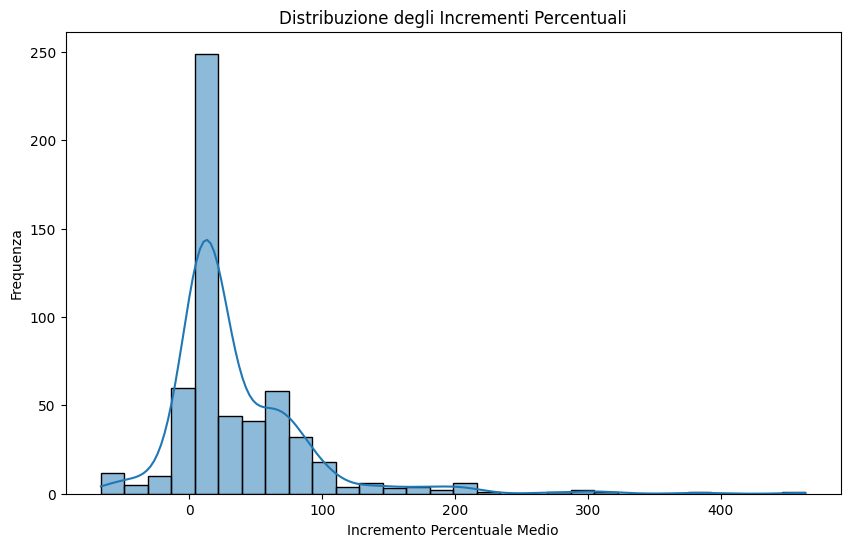

In [52]:
# Calcola la distribuzione degli incrementi percentuali
plt.figure(figsize=(10, 6))
sns.histplot(incremento_percentuale_medio['incremento_percentuale'], bins=30, kde=True)
plt.title('Distribuzione degli Incrementi Percentuali')
plt.xlabel('Incremento Percentuale Medio')
plt.ylabel('Frequenza')
plt.show()

In [53]:
# Statistiche descrittive
descr = incremento_percentuale_medio['incremento_percentuale'].describe()
print(descr)

count    561.000000
mean      35.689216
std       53.597296
min      -66.666667
25%        9.089036
50%       17.183254
75%       56.801578
max      463.636364
Name: incremento_percentuale, dtype: float64


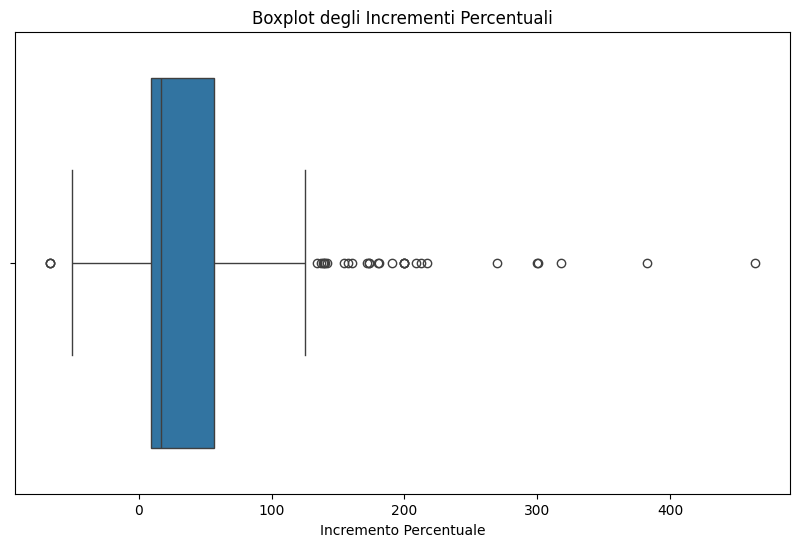

In [54]:
# Boxplot per identificare outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=incremento_percentuale_medio['incremento_percentuale'])
plt.title('Boxplot degli Incrementi Percentuali')
plt.xlabel('Incremento Percentuale')
plt.show()

In [55]:
# TODO: dobbiamo identificare anche il decremento?
    # IGNAZIO: si, ci possono essere degli incrementi percentuali medi negativi. Già verificato :(

def classify_increment(value):
    constat_increment = 5 
    low_increment = 15
    medium_increment = 40

    # TODO: fixare, bisogna mettere >= 0 nel primo if
    if value <= constat_increment and value >= 0:
        return 'constant_increment'
    elif value <= low_increment:
        return 'low_increment'
    elif value <= medium_increment:
        return 'medium_increment'
    elif value > medium_increment:
        return 'high_increment'
    else:
        return 'decrement'

In [56]:
incremento_percentuale_medio['incremento_teleassistenze'] = incremento_percentuale_medio['incremento_percentuale'].apply(classify_increment)

In [57]:
incremento_percentuale_medio.sort_values(by=['incremento_percentuale'], ascending=False)

,quadrimestre,regione_residenza,sesso,tipologia_struttura_erogazione,incremento_percentuale,incremento_teleassistenze
69,1,Molise,male,Ente di Ricerca,463.636364,high_increment
115,1,Sicilia,male,IRCCS privato,382.307692,high_increment
80,1,Piemonte,male,IRCCS privato,317.631918,high_increment
425,3,Toscana,female,Ente di Ricerca,300.476190,high_increment
61,1,Molise,female,Azienda Ospedaliera Universitaria,300.000000,high_increment
...,...,...,...,...,...,...
599,4,Valle d'aosta,female,IRCCS pubblico,NaN,decrement
601,4,Valle d'aosta,male,Azienda Ospedaliera,NaN,decrement
603,4,Valle d'aosta,male,Fondazione IRCCS,NaN,decrement
604,4,Valle d'aosta,male,IRCCS privato,NaN,decrement


In [58]:
mask = (incremento_percentuale_medio['incremento_teleassistenze'] == 'high_increment')
incremento_percentuale_medio[mask]


,quadrimestre,regione_residenza,sesso,tipologia_struttura_erogazione,incremento_percentuale,incremento_teleassistenze
0,1,Abruzzo,female,Ospedale a gestione diretta,73.881776,high_increment
1,1,Abruzzo,male,Ospedale a gestione diretta,63.729063,high_increment
2,1,Basilicata,female,Azienda Ospedaliera,69.200010,high_increment
3,1,Basilicata,female,IRCCS pubblico,75.000000,high_increment
4,1,Basilicata,female,Ospedale a gestione diretta,70.232390,high_increment
...,...,...,...,...,...,...
580,4,Toscana,female,Ente di Ricerca,101.243815,high_increment
583,4,Toscana,male,Ente di Ricerca,208.531124,high_increment
592,4,Umbria,male,Azienda Ospedaliera Universitaria,72.222222,high_increment
595,4,Umbria,male,IRCCS pubblico,50.000000,high_increment


In [59]:
# df['incremento_teleassistenze'] = df.apply(lambda x: incremento_percentuale_medio.loc[(incremento_percentuale_medio['regione_erogazione'] == x['regione_erogazione']) & (incremento_percentuale_medio['quadrimestre'] == x['quadrimestre'])]['incremento_teleassistenze'].values[0], axis=1)


# Qui vado a mappare il valore di incremento_teleassistenze nel dataframe principale (ci mette un po ad eseguirsi)


#df['incremento_teleassistenze'] = df.apply(lambda x: incremento_percentuale_medio.loc[
#    (incremento_percentuale_medio[df_cols_no_anno] == x[df_cols_no_anno].values).all(axis=1)
#]['incremento_teleassistenze'].values[0], axis=1)


In [60]:
df = df.merge(incremento_percentuale_medio[df_cols_no_anno + ['incremento_teleassistenze']], 
              on=df_cols_no_anno, 
              how='left')

In [61]:
df.to_parquet('../../data/processed/ds_labeled.parquet')


## CONTINUA NEL NOTEBOOK "importanza_feature_uff (non necessario per ora)

In [62]:
# mask = (df.regione_residenza == 'Lazio') & (df.sesso == 'male') & (df.tipologia_struttura_erogazione == 'Fondazione IRCCS') & (df.quadrimestre == 1)
# df[mask]

In [63]:
# mask = (df.regione_residenza == 'Abruzzo') & (df.sesso == 'female') & (df.tipologia_struttura_erogazione == 'Ospedale a gestione diretta') & (df.quadrimestre == 1)
# up = df[mask]

In [64]:
# up.incremento_teleassistenze.value_counts()